In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from lightgbm import LGBMClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
app_test = pd.read_csv("/content/drive/My Drive/FDS/application_test.csv")
app_train = pd.read_csv("/content/drive/My Drive/FDS/application_train.csv")

In [5]:
bureau=pd.read_csv("//content/drive/My Drive/FDS/bureau.csv")
samp_sub=pd.read_csv("/content/drive/My Drive/FDS/sample_submission.csv")
br_bal=pd.read_csv("/content/drive/My Drive/FDS/bureau_balance.csv")
ccb=pd.read_csv("/content/drive/My Drive/FDS/credit_card_balance.csv")
prev_appl=pd.read_csv("/content/drive/My Drive/FDS/previous_application.csv")
pos=pd.read_csv("/content/drive/My Drive/FDS/POS_CASH_balance.csv")
inp=pd.read_csv("/content/drive/My Drive/FDS/installments_payments.csv")

In [6]:
# Examine the missing values.
# Please note, we will just check the information on the missing values. 
# We will not remove any column as of now because we don't know which column is going to be important in future.
# Function to detect missing values.
def missing_info(dataframe):
    count=dataframe.isnull().sum()
  # standardised score of the missing values:
    mean_null=sum(count)/len(dataframe.columns)
    var_null=sum(((count-mean_null)**2))/len(dataframe.columns)
  # Make a table with the results
    metric=((count-mean_null)/var_null)*1000000
    result=pd.concat([count,metric],axis=1)
    result.columns=["count","standardised_score"]
    result=result[result.iloc[:,1] != 0].sort_values(
          'count', ascending=False).round(1)
    return(result.head())

In [7]:
missing_info(app_train)

,count,standardised_score
COMMONAREA_MEDI,214865,18.4
COMMONAREA_AVG,214865,18.4
COMMONAREA_MODE,214865,18.4
NONLIVINGAPARTMENTS_MODE,213514,18.2
NONLIVINGAPARTMENTS_AVG,213514,18.2


In [8]:
# The first hurdle we face is due to the columns with several categories. So, first we have to encode those columns to proceed further.
# Before that, let's have a look at the column types of the data sets.

#################### Function to check the column types #######################
def coltyp(dataframe):
    type=dataframe.dtypes.value_counts()
  #we will see number of unique categories for each object
    cat= dataframe.select_dtypes('object').apply(pd.Series.nunique,axis=0)
    print(type)
    return cat

In [9]:
coltyp(app_train)

float64    65
int64      41
object     16
dtype: int64


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [16]:
column =app_train[['DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL']]
column

,DAYS_EMPLOYED,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL
0,-637,-9461,406597.5,24700.5,351000.0,202500.0
1,-1188,-16765,1293502.5,35698.5,1129500.0,270000.0
2,-225,-19046,135000.0,6750.0,135000.0,67500.0
3,-3039,-19005,312682.5,29686.5,297000.0,135000.0
4,-3038,-19932,513000.0,21865.5,513000.0,121500.0
...,...,...,...,...,...,...
307506,-236,-9327,254700.0,27558.0,225000.0,157500.0
307507,365243,-20775,269550.0,12001.5,225000.0,72000.0
307508,-7921,-14966,677664.0,29979.0,585000.0,153000.0
307509,-4786,-11961,370107.0,20205.0,319500.0,171000.0


In [9]:
feat_train = pd.DataFrame()
feat_train['employment_to_birth_ratio'] = app_train['DAYS_EMPLOYED'] /app_train['DAYS_BIRTH']

feat_train['credit_to_annuity_ratio'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY']

feat_train['credit_to_goods_ratio'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']

feat_train['credit_to_income_ratio'] = app_train['AMT_CREDIT'] /  app_train['AMT_INCOME_TOTAL']

app_train=pd.concat([app_train,feat_train],axis=1)

In [10]:
feat_test = pd.DataFrame()
feat_test['employment_to_birth_ratio'] = app_test['DAYS_EMPLOYED'] /app_test['DAYS_BIRTH']

feat_test['credit_to_annuity_ratio'] = app_test['AMT_CREDIT'] / app_test['AMT_ANNUITY']

feat_test['credit_to_goods_ratio'] = app_test['AMT_CREDIT'] / app_test['AMT_GOODS_PRICE']

feat_test['credit_to_income_ratio'] = app_test['AMT_CREDIT'] /  app_test['AMT_INCOME_TOTAL']

app_test=pd.concat([app_test,feat_test],axis=1)

In [11]:
# Now we have to conduct the one hot encoding:

from sklearn.preprocessing import LabelEncoder as le
def onehot(dataframe):
    df=pd.get_dummies(dataframe)
    print(df.shape)
    return(df)

In [12]:
app_train=onehot(app_train)

(307511, 250)


In [13]:
app_test = onehot(app_test)

(48744, 246)


In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(app_train)
app_train.loc[:]=imputer.transform(app_train)

In [15]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(app_test)
app_test.loc[:]=imputer.transform(app_test)

In [16]:
app_train_target = app_train['TARGET']
app_train, app_test = app_train.align(app_test,join='inner',axis=1)
print('Training dataset shape: ', app_train.shape)
print('Testing dataset shape: ',app_test.shape)
app_train['TARGET'] = app_train_target

Training dataset shape:  (307511, 246)
Testing dataset shape:  (48744, 246)


#Working with bureau_balance and bureau dataset

In [26]:
br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Counting the values of all the status:\
C = Closed\
X = Status unknown\
0 = Current status, no delay\
1 = 1 month delay\
2 = 2 month delay\
3 = 3 month delay\
4 = 4 month delay


In [27]:
br_bal.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

Grouping the status with respect to the SK_ID_BUREAU of bureau_balance and then using unstack method to reshape the dataset formed by grouping. Some more columns are added by calculating the size, minimum and maximum value with respect to "SK_ID_BUREAU" using groupby function. Then the obtained unstack data is merged with bureau dataset.

In [17]:
bureau_counts = br_bal.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
bureau_counts_unstacked = bureau_counts.unstack('STATUS')

In [18]:
bureau_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
bureau_counts_unstacked['MONTHS_COUNT'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
bureau_counts_unstacked['MONTHS_MIN'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()
bureau_counts_unstacked['MONTHS_MAX'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()

In [19]:
bureau = bureau.join(bureau_counts_unstacked, how='left', on='SK_ID_BUREAU')

In [20]:
bureau.shape

(1716428, 28)

In [32]:
coltyp(bureau)

float64    19
int64       6
object      3
dtype: int64


CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [21]:
bureau=onehot(bureau)

(1716428, 48)


Further bureau dataset has been grouped by "SK_ID_CURR" and obtained the average. We can drop the "SK_ID_BUREAU" as the unique id "SK_ID_CURR" is enough to identify the corresponding values.

In [22]:
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['bureau_count'] = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del bureau_avg['SK_ID_BUREAU']

#Working with previous_application

In [ ]:
prev_appl.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Featuring using One-Hot-Encoding and applying groupby function to count and finding average

In [23]:
prev_appl = onehot(prev_appl)

(1670214, 164)


In [24]:
prev_appl_avg = prev_appl.groupby('SK_ID_CURR').mean()
prev_appl_count = prev_appl[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_appl_avg['nb_app'] = prev_appl_count['SK_ID_PREV']
del prev_appl_avg['SK_ID_PREV']

#Working with POS_CASH_Balance

In [ ]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [37]:
pos.NAME_CONTRACT_STATUS.value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [25]:
le = LabelEncoder()
pos['NAME_CONTRACT_STATUS'] = le.fit_transform(pos['NAME_CONTRACT_STATUS'].astype(str))
pos['UNIQUE_STATUS_COUNT'] = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()['NAME_CONTRACT_STATUS']
pos['UNIQUE_STATUS_MAX'] = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()['NAME_CONTRACT_STATUS']
pos.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

#Working with credit_card_balance

In [ ]:
ccb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [26]:
ccb['NAME_CONTRACT_STATUS'] = le.fit_transform(ccb['NAME_CONTRACT_STATUS'].astype(str))
ccb['UNIQUE_STATUS_COUNT'] = ccb[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby("SK_ID_CURR").nunique()["NAME_CONTRACT_STATUS"]
ccb['UNIQUE_STATUS2_MAX'] = ccb[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
ccb.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

#Working with installments_payments

In [ ]:
inp.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [27]:
inp_avg = inp.groupby('SK_ID_CURR').mean()
inp_max = inp.groupby('SK_ID_CURR').max()
inp_min = inp.groupby('SK_ID_CURR').min()
del inp_avg['SK_ID_PREV']

In [28]:
app_train = app_train.merge(right=prev_appl_avg.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=prev_appl_avg.reset_index(), how='left', on='SK_ID_CURR')

In [29]:
app_train = app_train.merge(right = bureau_avg.reset_index(), how="left", on="SK_ID_CURR")
app_test = app_test.merge(right = bureau_avg.reset_index(), how = "left", on="SK_ID_CURR")

In [30]:
app_train = app_train.merge(pos.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(pos.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

In [31]:
app_train = app_train.merge(ccb.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(ccb.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')


In [32]:
app_train = app_train.merge(right=inp_avg.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_avg.reset_index(), how='left', on='SK_ID_CURR')

In [33]:
app_train = app_train.merge(right=inp_max.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_max.reset_index(), how='left', on='SK_ID_CURR')


In [34]:
app_train = app_train.merge(right=inp_min.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_min.reset_index(), how='left', on='SK_ID_CURR')

In [35]:
del prev_appl_avg, bureau_avg, pos, ccb, inp_avg, inp_max, inp_min

In [36]:
del app_train["TARGET"]

In [37]:
app_train.shape

(307511, 505)

In [38]:
app_test.shape

(48744, 505)

In [39]:
app_train_target.shape

(307511,)

LightLGBM

In [ ]:
from lightgbm import LGBMClassifier
#lgb = LGBMClassifier()
lgb.fit(app_train, app_train_target)
predictions = lgb.predict_proba(app_test)[:,1]
output = app_test[['SK_ID_CURR']].astype(int)
output['TARGET'] = predictions

In [ ]:
output.to_csv("/content/drive/My Drive/FDS/lightgbm.csv", index=False)

In [ ]:
a = []
while(1):
    a.append(1)

0.821662162150897


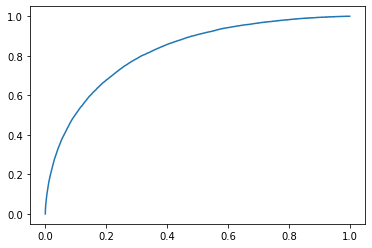

In [ ]:
p=lgb.predict_proba(app_train)[:,1]
print(roc_auc_score(app_train_target,p))
fpr,tpr,thr=roc_curve(app_train_target,p)
plt.figure()
plt.plot(fpr,tpr)

KFold

In [42]:
print('Removing features with more than 85% missing...')
test = app_test[app_test.columns[app_train.isnull().mean() < 0.85]]
data = app_train[app_train.columns[app_train.isnull().mean() < 0.85]]

Removing features with more than 80% missing...


In [43]:
#Delete customer Id
del data['SK_ID_CURR']
del test['SK_ID_CURR']

In [44]:
data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in data.columns]

In [45]:
test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test.columns]

In [76]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data, app_train_target, test_size=0.2, shuffle=True)

In [77]:
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [78]:
params = [          
          { 'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'learning_rate': 0.01,
            'max_depth':8,
            'num_leaves': 35,              
            'feature_fraction':0.125681745820782, 
            'bagging_freq': 5,
            'min_split_gain':0.0970905919552776,
            'min_child_weight':9.42012323936088,
            'reg_alpha':4.82988348810309,
            'reg_lambda':4.23709841316042,
            'verbose': 1},
          { 'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'learning_rate': 0.015,
            'max_depth':8,
            'num_leaves': 35,              
            'colsample_bytree':0.9497036,   
            'subsample':0.8715623,            
            'bagging_freq': 5,
            'min_split_gain':0.0222415,
            'min_child_weight':39.3259775,
            'reg_alpha':0.041545473,
            'reg_lambda':0.0735294,  
            'verbose': 1,},
    
          { 'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'learning_rate': 0.02,
            'max_depth':8,
            'num_leaves': 34,              
            'feature_fraction' : 0.125681745820782,
            'bagging_fraction' : 0.967396467593587,
            'bagging_freq':5,
            'min_split_gain':0.0970905919552776,
            'min_child_weight':9.42012323936088,
            'reg_alpha':4.82988348810309,
            'reg_lambda':4.23709841316042,
            'verbose': 1,}
         ]

In [79]:
debug = False
GLOBAL = False
num_rows = 20000 if debug else None
# cache_path = "./cache/v1/"
seed = 1024
# path = "../input/"

In [80]:
folds = StratifiedKFold(n_splits= 5 , shuffle=True, random_state=seed)

oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

feats = [f for f in data.columns if f not in  ['SK_ID_CURR',"TARGET"]]

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data, app_train_target)):
    X_train, y_train = data[feats].iloc[trn_idx], app_train_target.iloc[trn_idx]
    X_test, y_test = data[feats].iloc[val_idx], app_train_target.iloc[val_idx]

    lgb_train = lgb.Dataset(X_train, y_train)
    del X_train, y_train,
    lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)
        
    clf = lgb.train(params[1],
                    lgb_train,
                    num_boost_round=20000,
                    valid_sets=[lgb_eval],
                    early_stopping_rounds=200,
                    verbose_eval=100)

    oof_preds[val_idx] = clf.predict(X_test, num_iteration=clf.best_iteration)
    
    sub = pd.Series(clf.predict(test[feats], num_iteration=clf.best_iteration)).rank(pct=True).values
    sub_preds +=  sub / (folds.n_splits)
        
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = clf.feature_name()
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_test, oof_preds[val_idx])))
    del X_test, y_test
    gc.collect()

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.754761
[200]	valid_0's auc: 0.770119
[300]	valid_0's auc: 0.77711
[400]	valid_0's auc: 0.781074
[500]	valid_0's auc: 0.783316
[600]	valid_0's auc: 0.785023
[700]	valid_0's auc: 0.786161
[800]	valid_0's auc: 0.787133
[900]	valid_0's auc: 0.787687
[1000]	valid_0's auc: 0.788009
[1100]	valid_0's auc: 0.788388
[1200]	valid_0's auc: 0.788599
[1300]	valid_0's auc: 0.788702
[1400]	valid_0's auc: 0.788848
[1500]	valid_0's auc: 0.789005
[1600]	valid_0's auc: 0.789052
[1700]	valid_0's auc: 0.789177
[1800]	valid_0's auc: 0.78914
[1900]	valid_0's auc: 0.789179
[2000]	valid_0's auc: 0.7892
[2100]	valid_0's auc: 0.789237
[2200]	valid_0's auc: 0.7894
[2300]	valid_0's auc: 0.789403
[2400]	valid_0's auc: 0.789367
[2500]	valid_0's auc: 0.789455
[2600]	valid_0's auc: 0.789278
Early stopping, best iteration is:
[2477]	valid_0's auc: 0.789483
Fold  1 AUC : 0.789483
Training until validation scores don't improve for 200 ro

In [81]:
print('Full AUC score %.6f' % roc_auc_score(app_train_target, oof_preds)) 
test['TARGET'] = sub_preds

Full AUC score 0.788423


In [85]:
test[['SK_ID_CURR', 'TARGET']].to_csv('/content/drive/My Drive/FDS/submission_cross.csv', index=False)

In [84]:
test['SK_ID_CURR']=app ['SK_ID_CURR'].astype(int)

In [83]:
app= pd.read_csv("/content/drive/My Drive/FDS/application_test.csv")
